# I. Importing Libraries

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, zero_one_loss
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import os
import tensorflow
import tensorflow as tf
from tensorflow import keras

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

from tensorflow.keras import layers
from tensorflow.keras.layers import Layer, Add, InputSpec, Input, BatchNormalization, Dropout,Conv2D, Conv2DTranspose,AveragePooling2D, MaxPooling2D,Dense, Flatten, Reshape, Concatenate, Embedding, Lambda

from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout

from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.initializers import RandomNormal

!pwd

/var/folders/td/w85k3fwn2nn5xffjktw34x_m0000gn/T/ipykernel_2038/2652334549.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


/Users/tuongdoanvanngoc/Documents/Y3T3/378/AMS-Project/callai2/MyProject


In [2]:
from TAABLM_mechanism import GlobalContextLayer, AttentionMechanism, custom_objects
from Preprocessing_Data import load_and_preprocess_data, preprocess_texts, load_glove_embeddings, pad_tfidf

# II. Cleaning and Preparing Data

In [3]:
# datapath = data_dir + 'CallAIDataCorpus2.csv'
datapath = 'data/data.csv'

data,texts, unique_labels = load_and_preprocess_data(datapath)

In [4]:
# Preprocess texts
padded_sequences, tokenizer, X_tfidf, word_index, index_word = preprocess_texts(texts)

# Load GloVe embeddings
embedding_dim = 50
vocab_size = 10000
max_seq_len=100

embedding_matrix = load_glove_embeddings(vocab_size, embedding_dim, word_index)

# III. Splitting Data

In [5]:
# Assuming data['Text'], data['Category'], and tf_idf_tensor are available
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, data['Category'], test_size=0.2, random_state=42
)

# Split tf_idf_tensor separately to align with X_train and X_test
X_tfidf_train, X_tfidf_test = train_test_split(
    X_tfidf, test_size=0.2, random_state=42
)

# IV. TAABLM Model

In [6]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from TAABLM_mechanism import GlobalContextLayer, AttentionMechanism


# Input layers
input_sentence = Input(shape=(max_seq_len,), name="input_sentence")
input_tfidf = Input(shape=(X_tfidf.shape[1],), name="input_tfidf")

# Embedding layer
word_embeddings = layers.Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=True,
    name="word_embedding"
)(input_sentence)

# Global context
global_context = GlobalContextLayer(name="global_context")(word_embeddings)

# Attention mechanism
aspect_based_embedding = AttentionMechanism(embedding_dim=embedding_dim, name="attention_mechanism")(
    [word_embeddings, global_context]
)

# Batch normalization and dropout
aspect_based_embedding = layers.BatchNormalization(name="batch_norm")(aspect_based_embedding)
aspect_based_embedding = layers.Dropout(0.3, name="dropout")(aspect_based_embedding)

# Concatenate aspect-based embedding and TF-IDF input
final_embedding = layers.Concatenate(name="concatenate")([aspect_based_embedding, input_tfidf])

# Dense layers
hidden_layer = layers.Dense(128, activation="relu", kernel_regularizer=l2(0.01), name="hidden_layer")(final_embedding)
hidden_layer = layers.Dropout(0.5, name="dropout_after_dense")(hidden_layer)

# Output layer
output = Dense(len(np.unique(y_train)), activation="softmax", name="output")(hidden_layer)

# Build the multi-input model
model = Model(inputs=[input_sentence, input_tfidf], outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Early stopping callback
early_stopping = EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True, verbose=1
)

# Train the model
history = model.fit(
    [X_train, X_tfidf_train],  # Training inputs
    y_train,                   # Training labels
    validation_data=([X_test, X_tfidf_test], y_test),  # Validation inputs and labels
    epochs=20,                 # Number of epochs
    batch_size=32,             # Batch size
    callbacks=[early_stopping]  # Early stopping callback
)

2024-12-10 20:28:36.998692: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-12-10 20:28:36.998752: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-12-10 20:28:36.998763: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-12-10 20:28:36.998785: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-10 20:28:36.998799: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/20


/opt/miniconda3/envs/gpu/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_sentence', 'input_tfidf']. Received: the structure of inputs=('*', '*')
  warnings.warn(
2024-12-10 20:28:37.883876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.3626 - loss: 2.7431 - val_accuracy: 0.3615 - val_loss: 2.2245
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5521 - loss: 1.7622 - val_accuracy: 0.3808 - val_loss: 1.8196
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.6357 - loss: 1.3458 - val_accuracy: 0.4865 - val_loss: 1.5708
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.6781 - loss: 1.1400 - val_accuracy: 0.6058 - val_loss: 1.3799
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.7205 - loss: 1.0059 - val_accuracy: 0.7038 - val_loss: 1.1628
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.7528 - loss: 0.8892 - val_accuracy: 0.7712 - val_loss: 0.9636
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.7532 - loss: 0.8470 - val_accuracy: 0.7923 - val_loss: 0.8207
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.8130 - loss: 0.7399 - val_accuracy: 0.7885 - val_loss: 0.

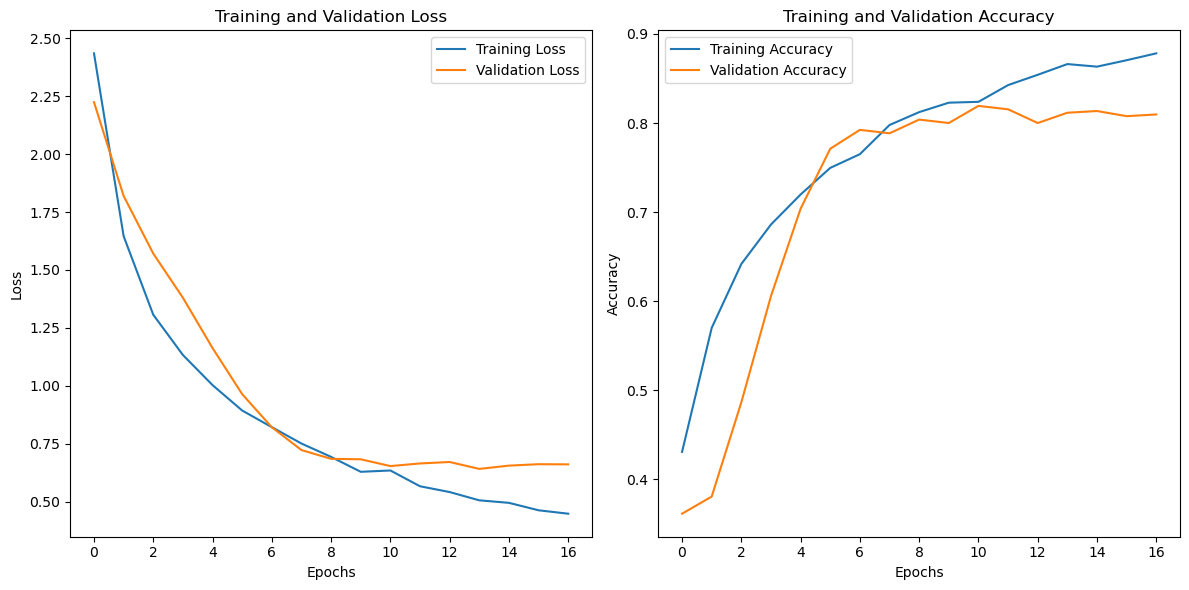

In [7]:
import matplotlib.pyplot as plt

# Plot the loss curve
plt.figure(figsize=(12, 6))

# Training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


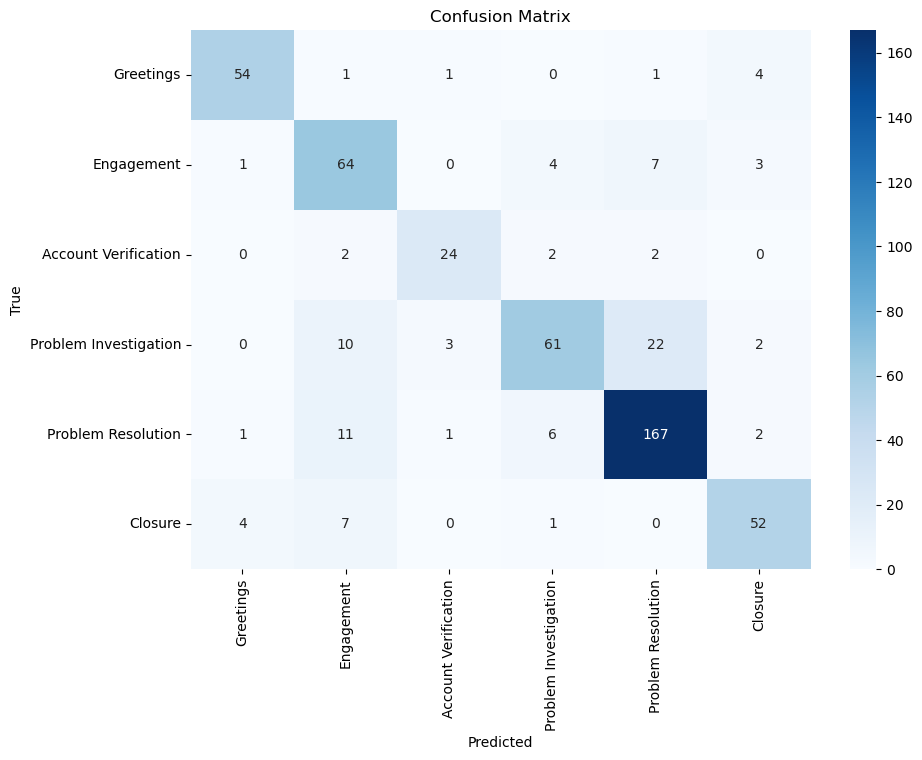

In [8]:
# Step 1: Predict on the test data
y_pred = model.predict([X_test, X_tfidf_test])
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the predicted class labels (softmax output)

# Step 2: Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Step 3: Plot confusion matrix using seaborn heatmap for better visualization
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [9]:
from sklearn.metrics import classification_report
import numpy as np

# Step 1: Predict on the test data
y_pred = model.predict([X_test, X_tfidf_test])  # Get predictions
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Step 2: Generate the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89        61
           1       0.67      0.81      0.74        79
           2       0.83      0.80      0.81        30
           3       0.82      0.62      0.71        98
           4       0.84      0.89      0.86       188
           5       0.83      0.81      0.82        64

    accuracy                           0.81       520
   macro avg       0.82      0.80      0.81       520
weighted avg       0.82      0.81      0.81       520



In [10]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_sentence      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ word_embedding      │ (None, 100, 50)   │    500,000 │ input_sentence[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_context      │ (None, 50)        │          0 │ word_embedding[0… │
│ (GlobalContextLaye… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mechanism │ (None, 50)        │      2,500 │ word_embedding[0… │
│ (AttentionMechanis… │                   │            │ global_context[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_norm          │ (None, 50)        │        200 │ attention_mechan… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 50)        │          0 │ batch_norm[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_tfidf         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 150)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ input_tfidf[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden_layer        │ (None, 128)       │     19,328 │ concatenate[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_after_dense │ (None, 128)       │          0 │ hidden_layer[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 6)         │        774 │ dropout_after_de… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,568,208 (5.98 MB)

 Trainable params: 522,702 (1.99 MB)

 Non-trainable params: 100 (400.00 B)

 Optimizer params: 1,045,406 (3.99 MB)

In [11]:
# Specify the directory to create
dir_name = 'TAABLM_model'  # Replace with your desired path

# Create the directory
os.makedirs(dir_name, exist_ok=True)
model.save(os.path.join(dir_name, 'TAABLM_Section.h5'))

In [12]:
# Save the model architecture in JSON format
model_json = model.to_json()
with open(os.path.join(dir_name, 'TAABLM_Section_architecture.json'), 'w') as json_file:
    json_file.write(model_json)

# Save the model weights in H5 format
model.save(os.path.join(dir_name, 'TAABLM_Section_weights.h5'))